<a href="https://colab.research.google.com/github/afrahhassan/afrahhassan/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
# <div align="center"><font>  </font></div>
# <div align="center"><font> COSC 2793 Computational Machine Learning </font></div>
## <div align="center"> <font> Assignment 2: Machine Learning Project </font></div>
## <div align="center"> <font> S3930076 Afrah Hassan A Alshaikh Ali & S3569266 Chang Su </font></div>
---

In [54]:
#Import Libraries
import os
import csv
import zipfile
import pandas as pd
import cv2
import numpy as np



# **1. Load and Preprocess the Data**

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
os.listdir('/content/drive/MyDrive/Assignment2')

['assignment2_PG.pdf',
 'COSC2673_2793_A2_EOI_.docx',
 'trafficsigns_dataset',
 'trafficsigns_dataset.zip',
 'shape.csv',
 'type.csv',
 'assignment2.ipynb']

In [56]:
!cp -r "/content/drive/MyDrive/Assignment2" .

In [57]:
zip_file_path = '/content/drive/My Drive/Assignment2/trafficsigns_dataset.zip'
extract_to_path = '/content/trafficsigns_dataset'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
print("Extraction completed!")

Extraction completed!


Load the images and corresponding labels from the dataset.

### Export shape to csv


In [59]:
root_dir = '/content/trafficsigns_dataset'
output_csv = '/content/drive/My Drive/Assignment2/shape.csv'

with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'class'])

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                class_name = os.path.basename(os.path.dirname(root))
                writer.writerow([full_path, class_name])

print("CSV file has been created successfully.")

CSV file has been created successfully.


### Export type to csv

In [58]:
root_dir = '/content/trafficsigns_dataset'
output_csv = '/content/drive/My Drive/Assignment2/type.csv'
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'class'])

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                class_name = os.path.basename(root)
                writer.writerow([full_path, class_name])
print("CSV file has been created successfully.")

CSV file has been created successfully.


find each type and shape


In [60]:
# Load the data from the CSV file
data_1 = pd.read_csv('/content/drive/My Drive/Assignment2/shape.csv')
data_1.head()

,image_path,class
0,/content/trafficsigns_dataset/trafficsigns_dat...,round
1,/content/trafficsigns_dataset/trafficsigns_dat...,round
2,/content/trafficsigns_dataset/trafficsigns_dat...,round
3,/content/trafficsigns_dataset/trafficsigns_dat...,round
4,/content/trafficsigns_dataset/trafficsigns_dat...,round


In [61]:
# Find the number of unique types/classes
num_shapes = data_1['class'].nunique()

# Get the count of each unique type/class
shape_counts = data_1['class'].value_counts()

print("Number of unique shapes:", num_shapes)
print("unique shapes:", shape_counts)

Number of unique shapes: 5
unique shapes: class
round       3520
triangle    1852
square      1376
diamond      564
hex           86
Name: count, dtype: int64


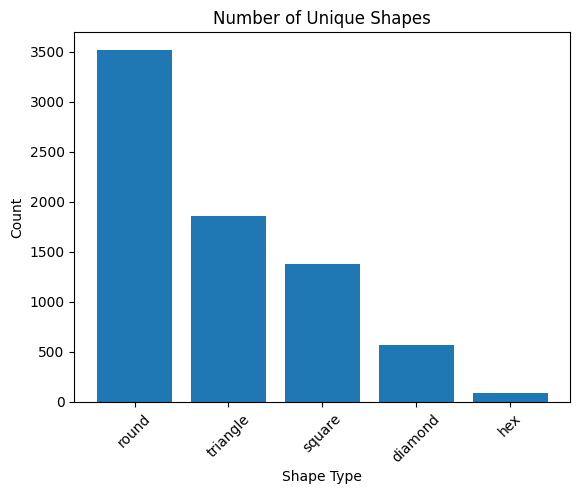

In [62]:
#Plot the shapes
# Import necessary libraries
import matplotlib.pyplot as plt

# Extract data for plotting
class_names = shape_counts.index.to_list()
class_counts = shape_counts.to_numpy()

# Create a bar plot
plt.bar(class_names, class_counts)

# Add title and labels
plt.title("Number of Unique Shapes")
plt.xlabel("Shape Type")
plt.ylabel("Count")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [63]:
# Load the data from the CSV file
data_2 = pd.read_csv('/content/drive/My Drive/Assignment2/type.csv')
data_2.head()


,image_path,class
0,/content/trafficsigns_dataset/trafficsigns_dat...,noentry
1,/content/trafficsigns_dataset/trafficsigns_dat...,noentry
2,/content/trafficsigns_dataset/trafficsigns_dat...,noentry
3,/content/trafficsigns_dataset/trafficsigns_dat...,noentry
4,/content/trafficsigns_dataset/trafficsigns_dat...,noentry


In [64]:
# Find the number of unique types/classes
num_types = data_2['class'].nunique()
# Get the count of each unique type/class
type_counts = data_2['class'].value_counts()

print("Number of unique types:", num_types)
print("unique types:", type_counts)

Number of unique types: 16
unique types: class
warning             1390
noentry              750
speed                632
bicycle              570
rightofway           564
parking              552
noparking            484
giveway              462
continue             398
trafficdirective     390
limitedtraffic       250
traveldirection      248
laneend              236
roundabout           196
crossing             190
stop                  86
Name: count, dtype: int64


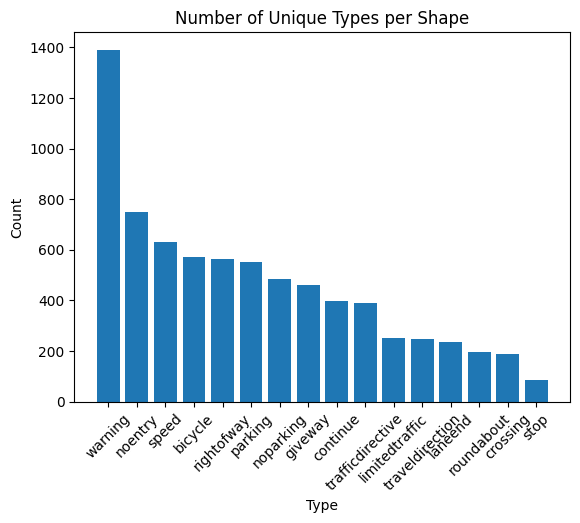

In [65]:
#Plot the types
# Import necessary libraries
import matplotlib.pyplot as plt

# Extract data for plotting
class_names = type_counts.index.to_list()
class_counts = type_counts.to_numpy()

# Create a bar plot
plt.bar(class_names, class_counts)

# Add title and labels
plt.title("Number of Unique Types per Shape")
plt.xlabel("Type")
plt.ylabel("Count")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

Convert images to numbers


In [53]:
# from sklearn.preprocessing import LabelEncoder

# # Create a LabelEncoder object
# encoder = LabelEncoder()

# # Encode the "class" column in shape.csv
# data_1['class'] = encoder.fit_transform(data_1['class'])

# # Encode the "class" column in type.csv
# data_2['class'] = encoder.fit_transform(data_2['class'])

# # Now both "shape" and "type" columns are encoded


In [66]:
from sklearn.preprocessing import LabelEncoder
# Create separate LabelEncoder objects for shape and type
shape_encoder = LabelEncoder()
type_encoder = LabelEncoder()

# Encode the shape and type columns
data_1['shape_encoded'] = shape_encoder.fit_transform(data_1['class'])  #7398
data_2['type_encoded'] = type_encoder.fit_transform(data_2['class'])  #7398

# Now you can train your models using the encoded columns

In [68]:
data_2.head()

,image_path,class,type_encoded
0,/content/trafficsigns_dataset/trafficsigns_dat...,noentry,6
1,/content/trafficsigns_dataset/trafficsigns_dat...,noentry,6
2,/content/trafficsigns_dataset/trafficsigns_dat...,noentry,6
3,/content/trafficsigns_dataset/trafficsigns_dat...,noentry,6
4,/content/trafficsigns_dataset/trafficsigns_dat...,noentry,6


In [79]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Define the path to the dataset
dataset_path = '/content/trafficsigns_dataset'

# Load the images and labels
images = []
labels = []

for sign_type_folder in os.listdir(dataset_path):
    for sign_shape_folder in os.listdir(os.path.join(dataset_path, sign_type_folder)):
        for image_filename in os.listdir(os.path.join(dataset_path, sign_type_folder, sign_shape_folder)):
            image_path = os.path.join(dataset_path, sign_type_folder, sign_shape_folder, image_filename)

            # Skip hidden files and directories
            if image_filename.startswith('.'):
                continue

            # Load the image
            image = cv2.imread(image_path)

            # Check if the file is an image
            if image is None:
                print(f"Skipping non-image file: {image_path}")
                continue

            # Preprocess the image
            image = cv2.resize(image, (28, 28))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            images.append(image)

            # Convert the sign type and shape to numerical labels
            sign_type_label = sign_type_folder
            sign_shape_label = sign_shape_folder
            labels.append([sign_type_label, sign_shape_label])

# Normalize the images
images = np.array(images) / 255.0

# Convert the labels to one-hot encoded format


NotADirectoryError: [Errno 20] Not a directory: '/content/trafficsigns_dataset/trafficsigns_dataset/.DS_Store'

# **2. Split the Data**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data,  # The encoded data
    target,  # The target variable (e.g., "class")
    test_size=0.2,  # The proportion of data to use for testing (20%)
    random_state=42  # Seed for random number generator
)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,  # The training data
    y_train_val,  # The target variable for training data
    test_size=0.2,  # The proportion of training data to use for validation (20%)
    random_state=42  # Seed for random number generator
)

# **3. Choose a Model**


Baseline Model


# **4. Train the Model**


# **5. Evaluate the Model**

In [80]:
import pandas as pd

shape_df = pd.read_csv('/content/drive/My Drive/Assignment2/shape.csv')
type_df = pd.read_csv('/content/drive/My Drive/Assignment2/type.csv')


In [81]:
merged_df = pd.merge(shape_df, type_df, on='image_path')

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Define the model architecture
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(images, labels, epochs=10)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Print the results
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential" expects 1 input(s), but it received 3699 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:16' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:17' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:18' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:19' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:20' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:21' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:22' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:23' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:24' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:25' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:26' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:27' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:28' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:29' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:30' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:31' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:32' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:33' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:34' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:35' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:36' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:37' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:38' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:39' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:40' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:41' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:42' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:43' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:44' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:45' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:46' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:47' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:48' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:49' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:50' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:51' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:52' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:53' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:54' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:55' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:56' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:57' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:58' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:59' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:60' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:61' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:62' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:63' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:64' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:65' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:66' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:67' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:68' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:69' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:70' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:71' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:72' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:73' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:74' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:75' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:76' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:77' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:78' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:79' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:80' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:81' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:82' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:83' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:84' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:85' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:86' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:87' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:88' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:89' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:90' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:91' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:92' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:93' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:94' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:95' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:96' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:97' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:98' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:99' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:100' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:101' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:102' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:103' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:104' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:105' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:106' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:107' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:108' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:109' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:110' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:111' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:112' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:113' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:114' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:115' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:116' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:117' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:118' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:119' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:120' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:121' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:122' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:123' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:124' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:125' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:126' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:127' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:128' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:129' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:130' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:131' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:132' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:133' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:134' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:135' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:136' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:137' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:138' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:139' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:140' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:141' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:142' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:143' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:144' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:145' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:146' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:147' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:148' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:149' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:150' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:151' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:152' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:153' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:154' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:155' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:156' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:157' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:158' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:159' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:160' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:161' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:162' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:163' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:164' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:165' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:166' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:167' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:168' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:169' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:170' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:171' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:172' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:173' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:174' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:175' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:176' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:177' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:178' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:179' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:180' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:181' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:182' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:183' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:184' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:185' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:186' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:187' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:188' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:189' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:190' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:191' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:192' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:193' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:194' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:195' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:196' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:197' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:198' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:199' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:200' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:201' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:202' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:203' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:204' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:205' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:206' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:207' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:208' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:209' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:210' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:211' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:212' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:213' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:214' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:215' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:216' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:217' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:218' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:219' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:220' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:221' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:222' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:223' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:224' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:225' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:226' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:227' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:228' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:229' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:230' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:231' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:232' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:233' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:234' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:235' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:236' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:237' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:238' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:239' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:240' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:241' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:242' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:243' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:244' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:245' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:246' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:247' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:248' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:249' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:250' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:251' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:252' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:253' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:254' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:255' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:256' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:257' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:258' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:259' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:260' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:261' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:262' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:263' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:264' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:265' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:266' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:267' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:268' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:269' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:270' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:271' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:272' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:273' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:274' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:275' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:276' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:277' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:278' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:279' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:280' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:281' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:282' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:283' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:284' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:285' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:286' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:287' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:288' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:289' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:290' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:291' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:292' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:293' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:294' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:295' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:296' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:297' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:298' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:299' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:300' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:301' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:302' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:303' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:304' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:305' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:306' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:307' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:308' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:309' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:310' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:311' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:312' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:313' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:314' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:315' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:316' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:317' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:318' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:319' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:320' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:321' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:322' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:323' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:324' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:325' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:326' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:327' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:328' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:329' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:330' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:331' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:332' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:333' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:334' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:335' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:336' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:337' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:338' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:339' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:340' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:341' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:342' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:343' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:344' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:345' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:346' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:347' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:348' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:349' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:350' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:351' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:352' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:353' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:354' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:355' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:356' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:357' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:358' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:359' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:360' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:361' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:362' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:363' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:364' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:365' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:366' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:367' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:368' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:369' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:370' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:371' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:372' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:373' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:374' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:375' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:376' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:377' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:378' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:379' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:380' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:381' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:382' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:383' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:384' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:385' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:386' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:387' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:388' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:389' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:390' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:391' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:392' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:393' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:394' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:395' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:396' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:397' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:398' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:399' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:400' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:401' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:402' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:403' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:404' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:405' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:406' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:407' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:408' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:409' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:410' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:411' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:412' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:413' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:414' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:415' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:416' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:417' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:418' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:419' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:420' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:421' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:422' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:423' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:424' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:425' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:426' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:427' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:428' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:429' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:430' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:431' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:432' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:433' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:434' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:435' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:436' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:437' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:438' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:439' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:440' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:441' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:442' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:443' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:444' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:445' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:446' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:447' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:448' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:449' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:450' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:451' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:452' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:453' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:454' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:455' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:456' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:457' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:458' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:459' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:460' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:461' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:462' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:463' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:464' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:465' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:466' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:467' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:468' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:469' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:470' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:471' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:472' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:473' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:474' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:475' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:476' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:477' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:478' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:479' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:480' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:481' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:482' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:483' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:484' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:485' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:486' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:487' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:488' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:489' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:490' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:491' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:492' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:493' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:494' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:495' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:496' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:497' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:498' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:499' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:500' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:501' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:502' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:503' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:504' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:505' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:506' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:507' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:508' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:509' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:510' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:511' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:512' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:513' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:514' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:515' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:516' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:517' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:518' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:519' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:520' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:521' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:522' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:523' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:524' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:525' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:526' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:527' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:528' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:529' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:530' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:531' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:532' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:533' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:534' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:535' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:536' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:537' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:538' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:539' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:540' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:541' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:542' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:543' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:544' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:545' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:546' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:547' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:548' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:549' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:550' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:551' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:552' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:553' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:554' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:555' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:556' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:557' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:558' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:559' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:560' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:561' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:562' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:563' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:564' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:565' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:566' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:567' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:568' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:569' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:570' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:571' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:572' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:573' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:574' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:575' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:576' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:577' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:578' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:579' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:580' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:581' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:582' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:583' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:584' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:585' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:586' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:587' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:588' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:589' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:590' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:591' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:592' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:593' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:594' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:595' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:596' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:597' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:598' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:599' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:600' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:601' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:602' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:603' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:604' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:605' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:606' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:607' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:608' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:609' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:610' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:611' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:612' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:613' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:614' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:615' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:616' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:617' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:618' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:619' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:620' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:621' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:622' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:623' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:624' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:625' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:626' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:627' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:628' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:629' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:630' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:631' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:632' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:633' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:634' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:635' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:636' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:637' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:638' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:639' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:640' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:641' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:642' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:643' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:644' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:645' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:646' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:647' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:648' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:649' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:650' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:651' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:652' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:653' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:654' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:655' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:656' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:657' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:658' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:659' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:660' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:661' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:662' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:663' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:664' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:665' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:666' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:667' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:668' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:669' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:670' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:671' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:672' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:673' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:674' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:675' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:676' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:677' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:678' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:679' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:680' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:681' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:682' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:683' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:684' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:685' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:686' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:687' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:688' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:689' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:690' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:691' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:692' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:693' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:694' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:695' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:696' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:697' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:698' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:699' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:700' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:701' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:702' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:703' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:704' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:705' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:706' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:707' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:708' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:709' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:710' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:711' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:712' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:713' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:714' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:715' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:716' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:717' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:718' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:719' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:720' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:721' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:722' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:723' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:724' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:725' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:726' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:727' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:728' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:729' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:730' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:731' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:732' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:733' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:734' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:735' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:736' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:737' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:738' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:739' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:740' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:741' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:742' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:743' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:744' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:745' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:746' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:747' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:748' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:749' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:750' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:751' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:752' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:753' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:754' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:755' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:756' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:757' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:758' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:759' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:760' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:761' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:762' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:763' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:764' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:765' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:766' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:767' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:768' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:769' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:770' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:771' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:772' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:773' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:774' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:775' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:776' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:777' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:778' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:779' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:780' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:781' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:782' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:783' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:784' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:785' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:786' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:787' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:788' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:789' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:790' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:791' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:792' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:793' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:794' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:795' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:796' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:797' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:798' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:799' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:800' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:801' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:802' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:803' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:804' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:805' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:806' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:807' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:808' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:809' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:810' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:811' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:812' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:813' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:814' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:815' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:816' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:817' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:818' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:819' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:820' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:821' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:822' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:823' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:824' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:825' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:826' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:827' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:828' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:829' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:830' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:831' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:832' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:833' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:834' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:835' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:836' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:837' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:838' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:839' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:840' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:841' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:842' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:843' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:844' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:845' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:846' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:847' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:848' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:849' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:850' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:851' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:852' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:853' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:854' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:855' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:856' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:857' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:858' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:859' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:860' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:861' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:862' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:863' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:864' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:865' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:866' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:867' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:868' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:869' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:870' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:871' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:872' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:873' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:874' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:875' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:876' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:877' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:878' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:879' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:880' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:881' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:882' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:883' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:884' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:885' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:886' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:887' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:888' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:889' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:890' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:891' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:892' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:893' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:894' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:895' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:896' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:897' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:898' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:899' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:900' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:901' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:902' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:903' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:904' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:905' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:906' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:907' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:908' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:909' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:910' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:911' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:912' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:913' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:914' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:915' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:916' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:917' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:918' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:919' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:920' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:921' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:922' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:923' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:924' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:925' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:926' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:927' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:928' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:929' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:930' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:931' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:932' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:933' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:934' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:935' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:936' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:937' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:938' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:939' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:940' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:941' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:942' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:943' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:944' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:945' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:946' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:947' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:948' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:949' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:950' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:951' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:952' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:953' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:954' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:955' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:956' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:957' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:958' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:959' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:960' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:961' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:962' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:963' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:964' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:965' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:966' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:967' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:968' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:969' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:970' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:971' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:972' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:973' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:974' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:975' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:976' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:977' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:978' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:979' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:980' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:981' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:982' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:983' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:984' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:985' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:986' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:987' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:988' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:989' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:990' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:991' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:992' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:993' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:994' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:995' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:996' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:997' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:998' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:999' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1000' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1001' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1002' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1003' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1004' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1005' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1006' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1007' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1008' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1009' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1010' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1011' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1012' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1013' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1014' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1015' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1016' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1017' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1018' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1019' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1020' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1021' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1022' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1023' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1024' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1025' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1026' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1027' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1028' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1029' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1030' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1031' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1032' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1033' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1034' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1035' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1036' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1037' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1038' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1039' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1040' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1041' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1042' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1043' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1044' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1045' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1046' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1047' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1048' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1049' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1050' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1051' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1052' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1053' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1054' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1055' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1056' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1057' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1058' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1059' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1060' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1061' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1062' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1063' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1064' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1065' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1066' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1067' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1068' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1069' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1070' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1071' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1072' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1073' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1074' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1075' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1076' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1077' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1078' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1079' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1080' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1081' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1082' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1083' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1084' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1085' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1086' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1087' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1088' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1089' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1090' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1091' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1092' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1093' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1094' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1095' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1096' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1097' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1098' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1099' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1100' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1101' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1102' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1103' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1104' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1105' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1106' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1107' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1108' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1109' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1110' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1111' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1112' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1113' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1114' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1115' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1116' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1117' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1118' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1119' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1120' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1121' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1122' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1123' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1124' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1125' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1126' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1127' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1128' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1129' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1130' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1131' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1132' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1133' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1134' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1135' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1136' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1137' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1138' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1139' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1140' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1141' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1142' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1143' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1144' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1145' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1146' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1147' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1148' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1149' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1150' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1151' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1152' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1153' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1154' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1155' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1156' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1157' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1158' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1159' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1160' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1161' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1162' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1163' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1164' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1165' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1166' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1167' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1168' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1169' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1170' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1171' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1172' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1173' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1174' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1175' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1176' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1177' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1178' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1179' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1180' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1181' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1182' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1183' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1184' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1185' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1186' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1187' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1188' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1189' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1190' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1191' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1192' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1193' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1194' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1195' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1196' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1197' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1198' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1199' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1200' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1201' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1202' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1203' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1204' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1205' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1206' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1207' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1208' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1209' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1210' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1211' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1212' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1213' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1214' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1215' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1216' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1217' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1218' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1219' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1220' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1221' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1222' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1223' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1224' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1225' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1226' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1227' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1228' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1229' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1230' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1231' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1232' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1233' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1234' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1235' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1236' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1237' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1238' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1239' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1240' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1241' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1242' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1243' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1244' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1245' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1246' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1247' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1248' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1249' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1250' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1251' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1252' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1253' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1254' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1255' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1256' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1257' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1258' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1259' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1260' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1261' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1262' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1263' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1264' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1265' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1266' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1267' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1268' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1269' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1270' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1271' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1272' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1273' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1274' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1275' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1276' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1277' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1278' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1279' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1280' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1281' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1282' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1283' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1284' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1285' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1286' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1287' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1288' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1289' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1290' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1291' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1292' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1293' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1294' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1295' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1296' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1297' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1298' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1299' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1300' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1301' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1302' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1303' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1304' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1305' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1306' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1307' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1308' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1309' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1310' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1311' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1312' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1313' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1314' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1315' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1316' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1317' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1318' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1319' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1320' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1321' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1322' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1323' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1324' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1325' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1326' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1327' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1328' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1329' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1330' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1331' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1332' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1333' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1334' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1335' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1336' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1337' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1338' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1339' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1340' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1341' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1342' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1343' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1344' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1345' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1346' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1347' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1348' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1349' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1350' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1351' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1352' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1353' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1354' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1355' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1356' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1357' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1358' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1359' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1360' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1361' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1362' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1363' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1364' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1365' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1366' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1367' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1368' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1369' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1370' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1371' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1372' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1373' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1374' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1375' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1376' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1377' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1378' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1379' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1380' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1381' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1382' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1383' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1384' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1385' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1386' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1387' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1388' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1389' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1390' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1391' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1392' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1393' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1394' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1395' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1396' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1397' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1398' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1399' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1400' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1401' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1402' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1403' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1404' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1405' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1406' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1407' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1408' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1409' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1410' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1411' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1412' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1413' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1414' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1415' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1416' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1417' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1418' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1419' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1420' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1421' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1422' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1423' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1424' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1425' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1426' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1427' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1428' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1429' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1430' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1431' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1432' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1433' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1434' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1435' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1436' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1437' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1438' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1439' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1440' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1441' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1442' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1443' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1444' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1445' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1446' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1447' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1448' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1449' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1450' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1451' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1452' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1453' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1454' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1455' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1456' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1457' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1458' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1459' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1460' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1461' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1462' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1463' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1464' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1465' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1466' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1467' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1468' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1469' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1470' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1471' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1472' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1473' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1474' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1475' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1476' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1477' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1478' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1479' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1480' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1481' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1482' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1483' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1484' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1485' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1486' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1487' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1488' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1489' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1490' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1491' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1492' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1493' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1494' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1495' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1496' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1497' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1498' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1499' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1500' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1501' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1502' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1503' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1504' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1505' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1506' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1507' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1508' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1509' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1510' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1511' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1512' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1513' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1514' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1515' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1516' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1517' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1518' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1519' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1520' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1521' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1522' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1523' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1524' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1525' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1526' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1527' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1528' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1529' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1530' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1531' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1532' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1533' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1534' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1535' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1536' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1537' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1538' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1539' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1540' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1541' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1542' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1543' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1544' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1545' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1546' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1547' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1548' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1549' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1550' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1551' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1552' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1553' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1554' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1555' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1556' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1557' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1558' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1559' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1560' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1561' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1562' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1563' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1564' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1565' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1566' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1567' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1568' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1569' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1570' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1571' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1572' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1573' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1574' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1575' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1576' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1577' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1578' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1579' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1580' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1581' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1582' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1583' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1584' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1585' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1586' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1587' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1588' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1589' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1590' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1591' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1592' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1593' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1594' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1595' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1596' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1597' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1598' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1599' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1600' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1601' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1602' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1603' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1604' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1605' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1606' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1607' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1608' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1609' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1610' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1611' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1612' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1613' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1614' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1615' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1616' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1617' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1618' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1619' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1620' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1621' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1622' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1623' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1624' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1625' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1626' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1627' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1628' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1629' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1630' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1631' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1632' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1633' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1634' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1635' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1636' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1637' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1638' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1639' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1640' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1641' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1642' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1643' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1644' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1645' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1646' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1647' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1648' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1649' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1650' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1651' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1652' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1653' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1654' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1655' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1656' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1657' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1658' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1659' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1660' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1661' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1662' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1663' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1664' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1665' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1666' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1667' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1668' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1669' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1670' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1671' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1672' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1673' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1674' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1675' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1676' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1677' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1678' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1679' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1680' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1681' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1682' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1683' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1684' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1685' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1686' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1687' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1688' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1689' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1690' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1691' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1692' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1693' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1694' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1695' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1696' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1697' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1698' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1699' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1700' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1701' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1702' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1703' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1704' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1705' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1706' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1707' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1708' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1709' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1710' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1711' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1712' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1713' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1714' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1715' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1716' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1717' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1718' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1719' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1720' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1721' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1722' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1723' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1724' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1725' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1726' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1727' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1728' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1729' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1730' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1731' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1732' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1733' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1734' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1735' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1736' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1737' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1738' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1739' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1740' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1741' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1742' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1743' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1744' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1745' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1746' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1747' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1748' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1749' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1750' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1751' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1752' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1753' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1754' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1755' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1756' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1757' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1758' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1759' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1760' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1761' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1762' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1763' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1764' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1765' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1766' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1767' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1768' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1769' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1770' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1771' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1772' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1773' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1774' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1775' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1776' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1777' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1778' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1779' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1780' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1781' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1782' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1783' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1784' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1785' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1786' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1787' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1788' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1789' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1790' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1791' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1792' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1793' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1794' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1795' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1796' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1797' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1798' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1799' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1800' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1801' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1802' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1803' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1804' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1805' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1806' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1807' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1808' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1809' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1810' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1811' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1812' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1813' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1814' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1815' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1816' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1817' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1818' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1819' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1820' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1821' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1822' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1823' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1824' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1825' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1826' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1827' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1828' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1829' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1830' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1831' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1832' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1833' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1834' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1835' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1836' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1837' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1838' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1839' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1840' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1841' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1842' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1843' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1844' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1845' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1846' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1847' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1848' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1849' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1850' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1851' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1852' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1853' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1854' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1855' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1856' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1857' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1858' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1859' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1860' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1861' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1862' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1863' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1864' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1865' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1866' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1867' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1868' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1869' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1870' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1871' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1872' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1873' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1874' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1875' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1876' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1877' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1878' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1879' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1880' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1881' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1882' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1883' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1884' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1885' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1886' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1887' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1888' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1889' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1890' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1891' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1892' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1893' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1894' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1895' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1896' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1897' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1898' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1899' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1900' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1901' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1902' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1903' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1904' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1905' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1906' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1907' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1908' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1909' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1910' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1911' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1912' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1913' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1914' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1915' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1916' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1917' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1918' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1919' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1920' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1921' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1922' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1923' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1924' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1925' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1926' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1927' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1928' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1929' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1930' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1931' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1932' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1933' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1934' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1935' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1936' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1937' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1938' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1939' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1940' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1941' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1942' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1943' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1944' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1945' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1946' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1947' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1948' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1949' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1950' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1951' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1952' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1953' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1954' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1955' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1956' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1957' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1958' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1959' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1960' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1961' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1962' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1963' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1964' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1965' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1966' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1967' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1968' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1969' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1970' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1971' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1972' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1973' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1974' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1975' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1976' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1977' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1978' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1979' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1980' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1981' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1982' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1983' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1984' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1985' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1986' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1987' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1988' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1989' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1990' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1991' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1992' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1993' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1994' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1995' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1996' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1997' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1998' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1999' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2000' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2001' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2002' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2003' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2004' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2005' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2006' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2007' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2008' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2009' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2010' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2011' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2012' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2013' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2014' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2015' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2016' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2017' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2018' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2019' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2020' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2021' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2022' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2023' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2024' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2025' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2026' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2027' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2028' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2029' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2030' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2031' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2032' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2033' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2034' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2035' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2036' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2037' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2038' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2039' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2040' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2041' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2042' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2043' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2044' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2045' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2046' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2047' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2048' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2049' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2050' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2051' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2052' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2053' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2054' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2055' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2056' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2057' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2058' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2059' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2060' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2061' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2062' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2063' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2064' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2065' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2066' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2067' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2068' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2069' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2070' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2071' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2072' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2073' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2074' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2075' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2076' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2077' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2078' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2079' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2080' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2081' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2082' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2083' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2084' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2085' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2086' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2087' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2088' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2089' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2090' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2091' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2092' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2093' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2094' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2095' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2096' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2097' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2098' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2099' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2100' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2101' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2102' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2103' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2104' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2105' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2106' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2107' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2108' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2109' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2110' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2111' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2112' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2113' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2114' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2115' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2116' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2117' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2118' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2119' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2120' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2121' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2122' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2123' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2124' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2125' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2126' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2127' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2128' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2129' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2130' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2131' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2132' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2133' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2134' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2135' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2136' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2137' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2138' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2139' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2140' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2141' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2142' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2143' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2144' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2145' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2146' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2147' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2148' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2149' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2150' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2151' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2152' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2153' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2154' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2155' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2156' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2157' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2158' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2159' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2160' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2161' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2162' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2163' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2164' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2165' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2166' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2167' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2168' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2169' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2170' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2171' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2172' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2173' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2174' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2175' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2176' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2177' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2178' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2179' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2180' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2181' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2182' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2183' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2184' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2185' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2186' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2187' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2188' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2189' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2190' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2191' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2192' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2193' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2194' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2195' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2196' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2197' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2198' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2199' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2200' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2201' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2202' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2203' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2204' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2205' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2206' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2207' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2208' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2209' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2210' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2211' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2212' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2213' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2214' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2215' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2216' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2217' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2218' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2219' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2220' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2221' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2222' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2223' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2224' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2225' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2226' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2227' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2228' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2229' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2230' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2231' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2232' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2233' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2234' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2235' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2236' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2237' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2238' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2239' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2240' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2241' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2242' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2243' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2244' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2245' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2246' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2247' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2248' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2249' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2250' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2251' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2252' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2253' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2254' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2255' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2256' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2257' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2258' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2259' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2260' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2261' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2262' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2263' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2264' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2265' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2266' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2267' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2268' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2269' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2270' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2271' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2272' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2273' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2274' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2275' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2276' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2277' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2278' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2279' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2280' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2281' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2282' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2283' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2284' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2285' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2286' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2287' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2288' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2289' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2290' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2291' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2292' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2293' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2294' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2295' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2296' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2297' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2298' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2299' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2300' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2301' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2302' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2303' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2304' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2305' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2306' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2307' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2308' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2309' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2310' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2311' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2312' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2313' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2314' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2315' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2316' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2317' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2318' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2319' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2320' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2321' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2322' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2323' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2324' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2325' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2326' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2327' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2328' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2329' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2330' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2331' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2332' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2333' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2334' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2335' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2336' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2337' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2338' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2339' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2340' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2341' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2342' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2343' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2344' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2345' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2346' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2347' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2348' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2349' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2350' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2351' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2352' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2353' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2354' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2355' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2356' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2357' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2358' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2359' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2360' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2361' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2362' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2363' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2364' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2365' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2366' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2367' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2368' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2369' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2370' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2371' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2372' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2373' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2374' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2375' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2376' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2377' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2378' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2379' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2380' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2381' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2382' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2383' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2384' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2385' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2386' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2387' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2388' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2389' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2390' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2391' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2392' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2393' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2394' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2395' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2396' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2397' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2398' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2399' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2400' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2401' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2402' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2403' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2404' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2405' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2406' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2407' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2408' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2409' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2410' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2411' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2412' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2413' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2414' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2415' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2416' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2417' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2418' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2419' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2420' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2421' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2422' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2423' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2424' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2425' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2426' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2427' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2428' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2429' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2430' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2431' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2432' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2433' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2434' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2435' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2436' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2437' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2438' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2439' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2440' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2441' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2442' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2443' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2444' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2445' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2446' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2447' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2448' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2449' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2450' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2451' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2452' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2453' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2454' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2455' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2456' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2457' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2458' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2459' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2460' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2461' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2462' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2463' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2464' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2465' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2466' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2467' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2468' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2469' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2470' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2471' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2472' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2473' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2474' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2475' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2476' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2477' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2478' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2479' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2480' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2481' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2482' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2483' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2484' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2485' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2486' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2487' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2488' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2489' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2490' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2491' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2492' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2493' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2494' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2495' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2496' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2497' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2498' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2499' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2500' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2501' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2502' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2503' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2504' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2505' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2506' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2507' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2508' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2509' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2510' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2511' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2512' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2513' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2514' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2515' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2516' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2517' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2518' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2519' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2520' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2521' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2522' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2523' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2524' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2525' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2526' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2527' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2528' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2529' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2530' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2531' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2532' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2533' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2534' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2535' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2536' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2537' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2538' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2539' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2540' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2541' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2542' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2543' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2544' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2545' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2546' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2547' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2548' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2549' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2550' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2551' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2552' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2553' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2554' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2555' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2556' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2557' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2558' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2559' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2560' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2561' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2562' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2563' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2564' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2565' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2566' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2567' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2568' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2569' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2570' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2571' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2572' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2573' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2574' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2575' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2576' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2577' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2578' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2579' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2580' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2581' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2582' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2583' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2584' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2585' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2586' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2587' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2588' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2589' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2590' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2591' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2592' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2593' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2594' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2595' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2596' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2597' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2598' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2599' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2600' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2601' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2602' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2603' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2604' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2605' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2606' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2607' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2608' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2609' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2610' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2611' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2612' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2613' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2614' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2615' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2616' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2617' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2618' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2619' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2620' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2621' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2622' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2623' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2624' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2625' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2626' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2627' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2628' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2629' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2630' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2631' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2632' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2633' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2634' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2635' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2636' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2637' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2638' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2639' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2640' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2641' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2642' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2643' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2644' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2645' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2646' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2647' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2648' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2649' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2650' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2651' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2652' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2653' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2654' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2655' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2656' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2657' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2658' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2659' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2660' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2661' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2662' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2663' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2664' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2665' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2666' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2667' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2668' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2669' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2670' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2671' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2672' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2673' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2674' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2675' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2676' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2677' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2678' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2679' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2680' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2681' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2682' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2683' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2684' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2685' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2686' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2687' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2688' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2689' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2690' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2691' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2692' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2693' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2694' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2695' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2696' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2697' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2698' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2699' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2700' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2701' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2702' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2703' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2704' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2705' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2706' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2707' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2708' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2709' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2710' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2711' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2712' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2713' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2714' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2715' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2716' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2717' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2718' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2719' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2720' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2721' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2722' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2723' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2724' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2725' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2726' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2727' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2728' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2729' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2730' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2731' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2732' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2733' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2734' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2735' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2736' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2737' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2738' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2739' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2740' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2741' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2742' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2743' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2744' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2745' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2746' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2747' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2748' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2749' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2750' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2751' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2752' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2753' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2754' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2755' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2756' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2757' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2758' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2759' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2760' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2761' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2762' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2763' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2764' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2765' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2766' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2767' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2768' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2769' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2770' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2771' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2772' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2773' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2774' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2775' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2776' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2777' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2778' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2779' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2780' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2781' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2782' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2783' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2784' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2785' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2786' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2787' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2788' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2789' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2790' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2791' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2792' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2793' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2794' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2795' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2796' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2797' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2798' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2799' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2800' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2801' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2802' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2803' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2804' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2805' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2806' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2807' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2808' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2809' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2810' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2811' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2812' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2813' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2814' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2815' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2816' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2817' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2818' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2819' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2820' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2821' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2822' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2823' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2824' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2825' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2826' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2827' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2828' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2829' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2830' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2831' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2832' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2833' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2834' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2835' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2836' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2837' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2838' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2839' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2840' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2841' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2842' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2843' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2844' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2845' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2846' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2847' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2848' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2849' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2850' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2851' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2852' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2853' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2854' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2855' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2856' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2857' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2858' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2859' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2860' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2861' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2862' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2863' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2864' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2865' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2866' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2867' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2868' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2869' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2870' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2871' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2872' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2873' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2874' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2875' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2876' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2877' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2878' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2879' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2880' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2881' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2882' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2883' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2884' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2885' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2886' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2887' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2888' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2889' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2890' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2891' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2892' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2893' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2894' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2895' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2896' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2897' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2898' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2899' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2900' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2901' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2902' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2903' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2904' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2905' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2906' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2907' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2908' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2909' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2910' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2911' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2912' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2913' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2914' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2915' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2916' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2917' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2918' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2919' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2920' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2921' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2922' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2923' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2924' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2925' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2926' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2927' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2928' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2929' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2930' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2931' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2932' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2933' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2934' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2935' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2936' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2937' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2938' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2939' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2940' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2941' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2942' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2943' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2944' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2945' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2946' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2947' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2948' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2949' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2950' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2951' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2952' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2953' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2954' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2955' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2956' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2957' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2958' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2959' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2960' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2961' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2962' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2963' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2964' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2965' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2966' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2967' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2968' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2969' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2970' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2971' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2972' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2973' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2974' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2975' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2976' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2977' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2978' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2979' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2980' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2981' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2982' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2983' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2984' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2985' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2986' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2987' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2988' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2989' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2990' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2991' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2992' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2993' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2994' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2995' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2996' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2997' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2998' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2999' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3000' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3001' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3002' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3003' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3004' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3005' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3006' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3007' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3008' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3009' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3010' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3011' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3012' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3013' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3014' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3015' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3016' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3017' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3018' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3019' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3020' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3021' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3022' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3023' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3024' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3025' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3026' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3027' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3028' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3029' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3030' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3031' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3032' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3033' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3034' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3035' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3036' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3037' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3038' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3039' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3040' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3041' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3042' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3043' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3044' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3045' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3046' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3047' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3048' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3049' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3050' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3051' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3052' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3053' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3054' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3055' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3056' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3057' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3058' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3059' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3060' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3061' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3062' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3063' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3064' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3065' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3066' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3067' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3068' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3069' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3070' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3071' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3072' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3073' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3074' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3075' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3076' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3077' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3078' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3079' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3080' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3081' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3082' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3083' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3084' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3085' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3086' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3087' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3088' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3089' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3090' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3091' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3092' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3093' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3094' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3095' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3096' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3097' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3098' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3099' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3100' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3101' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3102' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3103' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3104' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3105' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3106' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3107' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3108' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3109' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3110' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3111' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3112' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3113' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3114' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3115' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3116' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3117' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3118' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3119' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3120' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3121' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3122' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3123' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3124' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3125' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3126' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3127' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3128' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3129' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3130' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3131' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3132' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3133' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3134' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3135' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3136' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3137' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3138' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3139' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3140' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3141' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3142' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3143' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3144' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3145' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3146' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3147' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3148' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3149' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3150' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3151' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3152' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3153' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3154' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3155' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3156' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3157' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3158' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3159' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3160' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3161' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3162' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3163' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3164' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3165' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3166' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3167' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3168' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3169' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3170' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3171' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3172' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3173' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3174' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3175' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3176' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3177' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3178' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3179' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3180' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3181' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3182' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3183' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3184' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3185' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3186' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3187' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3188' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3189' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3190' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3191' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3192' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3193' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3194' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3195' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3196' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3197' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3198' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3199' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3200' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3201' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3202' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3203' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3204' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3205' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3206' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3207' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3208' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3209' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3210' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3211' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3212' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3213' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3214' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3215' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3216' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3217' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3218' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3219' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3220' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3221' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3222' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3223' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3224' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3225' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3226' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3227' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3228' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3229' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3230' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3231' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3232' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3233' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3234' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3235' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3236' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3237' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3238' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3239' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3240' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3241' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3242' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3243' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3244' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3245' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3246' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3247' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3248' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3249' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3250' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3251' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3252' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3253' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3254' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3255' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3256' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3257' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3258' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3259' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3260' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3261' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3262' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3263' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3264' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3265' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3266' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3267' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3268' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3269' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3270' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3271' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3272' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3273' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3274' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3275' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3276' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3277' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3278' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3279' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3280' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3281' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3282' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3283' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3284' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3285' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3286' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3287' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3288' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3289' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3290' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3291' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3292' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3293' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3294' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3295' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3296' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3297' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3298' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3299' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3300' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3301' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3302' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3303' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3304' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3305' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3306' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3307' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3308' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3309' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3310' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3311' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3312' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3313' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3314' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3315' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3316' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3317' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3318' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3319' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3320' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3321' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3322' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3323' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3324' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3325' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3326' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3327' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3328' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3329' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3330' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3331' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3332' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3333' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3334' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3335' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3336' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3337' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3338' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3339' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3340' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3341' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3342' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3343' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3344' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3345' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3346' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3347' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3348' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3349' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3350' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3351' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3352' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3353' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3354' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3355' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3356' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3357' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3358' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3359' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3360' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3361' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3362' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3363' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3364' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3365' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3366' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3367' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3368' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3369' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3370' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3371' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3372' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3373' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3374' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3375' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3376' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3377' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3378' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3379' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3380' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3381' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3382' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3383' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3384' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3385' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3386' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3387' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3388' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3389' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3390' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3391' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3392' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3393' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3394' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3395' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3396' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3397' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3398' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3399' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3400' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3401' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3402' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3403' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3404' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3405' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3406' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3407' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3408' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3409' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3410' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3411' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3412' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3413' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3414' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3415' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3416' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3417' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3418' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3419' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3420' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3421' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3422' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3423' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3424' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3425' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3426' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3427' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3428' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3429' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3430' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3431' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3432' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3433' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3434' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3435' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3436' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3437' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3438' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3439' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3440' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3441' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3442' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3443' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3444' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3445' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3446' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3447' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3448' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3449' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3450' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3451' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3452' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3453' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3454' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3455' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3456' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3457' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3458' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3459' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3460' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3461' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3462' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3463' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3464' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3465' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3466' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3467' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3468' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3469' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3470' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3471' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3472' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3473' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3474' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3475' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3476' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3477' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3478' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3479' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3480' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3481' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3482' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3483' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3484' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3485' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3486' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3487' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3488' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3489' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3490' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3491' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3492' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3493' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3494' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3495' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3496' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3497' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3498' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3499' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3500' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3501' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3502' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3503' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3504' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3505' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3506' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3507' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3508' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3509' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3510' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3511' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3512' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3513' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3514' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3515' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3516' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3517' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3518' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3519' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3520' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3521' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3522' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3523' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3524' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3525' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3526' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3527' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3528' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3529' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3530' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3531' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3532' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3533' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3534' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3535' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3536' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3537' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3538' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3539' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3540' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3541' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3542' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3543' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3544' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3545' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3546' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3547' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3548' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3549' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3550' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3551' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3552' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3553' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3554' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3555' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3556' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3557' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3558' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3559' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3560' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3561' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3562' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3563' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3564' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3565' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3566' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3567' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3568' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3569' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3570' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3571' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3572' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3573' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3574' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3575' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3576' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3577' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3578' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3579' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3580' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3581' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3582' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3583' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3584' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3585' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3586' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3587' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3588' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3589' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3590' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3591' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3592' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3593' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3594' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3595' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3596' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3597' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3598' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3599' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3600' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3601' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3602' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3603' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3604' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3605' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3606' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3607' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3608' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3609' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3610' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3611' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3612' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3613' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3614' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3615' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3616' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3617' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3618' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3619' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3620' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3621' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3622' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3623' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3624' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3625' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3626' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3627' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3628' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3629' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3630' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3631' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3632' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3633' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3634' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3635' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3636' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3637' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3638' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3639' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3640' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3641' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3642' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3643' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3644' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3645' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3646' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3647' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3648' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3649' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3650' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3651' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3652' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3653' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3654' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3655' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3656' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3657' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3658' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3659' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3660' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3661' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3662' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3663' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3664' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3665' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3666' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3667' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3668' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3669' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3670' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3671' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3672' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3673' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3674' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3675' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3676' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3677' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3678' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3679' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3680' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3681' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3682' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3683' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3684' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3685' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3686' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3687' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3688' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3689' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3690' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3691' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3692' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3693' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3694' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3695' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3696' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3697' shape=(None, 28) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3698' shape=(None, 28) dtype=uint8>]
